In [1]:
# Import libraries
import numpy as np
import tensorflow as tf
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.metrics import AUC, Precision, Recall
import pickle
from sklearn.metrics import precision_recall_curve, f1_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Charge X and y data that are in .npy format
X = np.load('../save_model/X.npy')
y = np.load('../save_model/y.npy')
X.shape, y.shape

((241, 300, 30), (241,))

In [3]:
# Divide data in train, val and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
#X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

In [4]:
def augment_sequence(x, noise_std=0.01, max_shift=5, scale_range=(0.9, 1.1), window_size=10):
    """
    Aplica aumento de datos a una secuencia individual de forma (300, 30)
    """
    # 1. Agregar ruido gaussiano
    noise = np.random.normal(0, noise_std, x.shape)
    x_aug = x + noise

    # 2. Desplazamiento temporal (shift)
    shift = np.random.randint(-max_shift, max_shift + 1)
    x_aug = np.roll(x_aug, shift, axis=0)

    # 3. Escalado
    scale = np.random.uniform(scale_range[0], scale_range[1])
    x_aug = x_aug * scale

    # 4. Permutación de subventanas
    num_segments = x.shape[0] // window_size
    segments = np.array_split(x_aug[:num_segments * window_size], num_segments, axis=0)
    np.random.shuffle(segments)
    x_aug = np.concatenate(segments, axis=0)

    return x_aug


def augment_dataset(X, y, augment_factor=2):
    """
    Aumenta el dataset X, y multiplicando los datos por augment_factor
    """
    X_aug = []
    y_aug = []

    for i in range(len(X)):
        for _ in range(augment_factor):
            x_new = augment_sequence(X[i])
            X_aug.append(x_new)
            y_aug.append(y[i])

    X_aug = np.array(X_aug)
    y_aug = np.array(y_aug)
    
    # Mezclamos con los originales si quieres:
    X_combined = np.concatenate([X, X_aug], axis=0)
    y_combined = np.concatenate([y, y_aug], axis=0)

    return X_combined, y_combined

In [5]:
X_train_augmented, y_train_augmented = augment_dataset(X_train, y_train, augment_factor=9)
print(X_train_augmented.shape)  # Debería ser (241 * 3, 300, 30)
print(y_train_augmented.shape)

(1530, 300, 30)
(1530,)


In [6]:
X_train_augmented.shape, y_train_augmented.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1530, 300, 30), (1530,), (39, 300, 30), (39,), (49, 300, 30), (49,))

In [7]:
# Calcular pesos automáticamente
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_augmented),
    y=y_train_augmented
)
class_weights = dict(enumerate(class_weights))

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks para entrenamiento robusto
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Construcción del modelo
model = Sequential([
    Masking(mask_value=0.0, input_shape=(300, 30)),  # En caso haya padding
    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.4),
    Bidirectional(LSTM(64)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')  # 4 clases de atención en DAiSEE
])

model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

d:\OneDrive - Universidad Peruana de Ciencias\Documents\Carrera\2025-1\TP1\videito\env\Lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
history = model.fit(
    X_train_augmented, y_train_augmented,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 25s 290ms/step - accuracy: 0.2443 - loss: 1.3989 - val_accuracy: 0.2564 - val_loss: 1.3868 - learning_rate: 1.0000e-04
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 261ms/step - accuracy: 0.2764 - loss: 1.3847 - val_accuracy: 0.2308 - val_loss: 1.3845 - learning_rate: 1.0000e-04
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 262ms/step - accuracy: 0.2843 - loss: 1.3797 - val_accuracy: 0.1795 - val_loss: 1.3859 - learning_rate: 1.0000e-04
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 259ms/step - accuracy: 0.2867 - loss: 1.3818 - val_accuracy: 0.2821 - val_loss: 1.3819 - learning_rate: 1.0000e-04
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 255ms/step - accuracy: 0.2884 - loss: 1.3706 - val_accuracy: 0.2564 - val_loss: 1.3716 - learning_rate: 1.0000e-04
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 257ms/step - accuracy: 0.3582 - loss: 1.3368 - val_accuracy: 0.2308 - val_loss: 1.3666 - learning_rate: 1.0000e-04
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 251ms/step - acc

In [42]:
X_train_augmented.shape, y_train_augmented.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape  

((1920, 300, 30), (1920,), (39, 300, 30), (39,), (49, 300, 30), (49,))

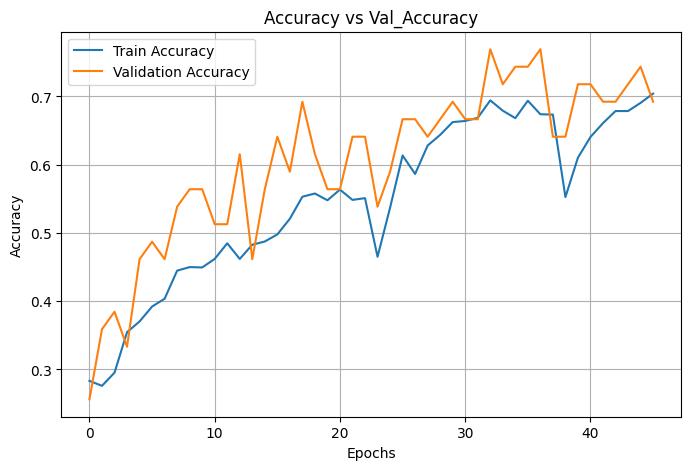

In [43]:
# Graficar accuracy de cada modelo
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Accuracy vs Val_Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
# Predicciones individuales de cada modelo
# make a summartory of X_val and X_test in a new variable
#X_val_test = np.concatenate([X_val, X_test], axis=0)
#y_val_test = np.concatenate([y_val, y_test], axis=0)
preds = model.predict(X_test)
final_preds = np.argmax(preds, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


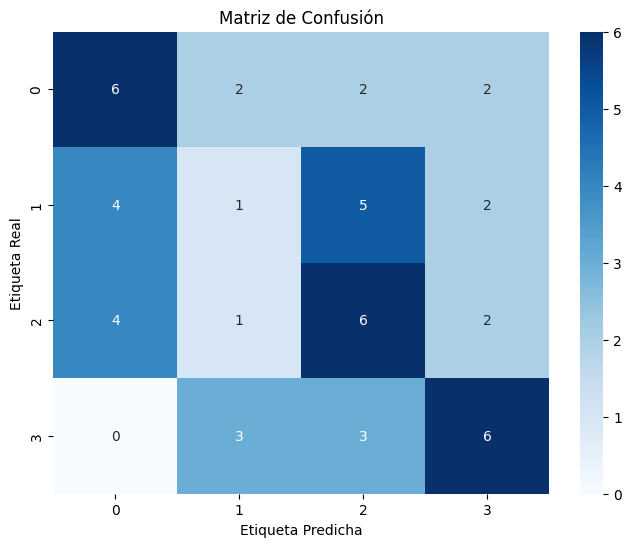

In [52]:
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(cm.shape[1]), yticklabels=np.arange(cm.shape[0]))
plt.title("Matriz de Confusión")
plt.xlabel("Etiqueta Predicha")
plt.ylabel("Etiqueta Real")
plt.show()

In [2]:
# view classification report
print(classification_report(y_test, final_preds, digits=3))

NameError: name 'classification_report' is not defined

In [1]:
# Save the model
model.save('../save_model/TCN_38.h5')
# Save the history
with open('../save_model/history_TCN_38.pkl', 'wb') as f:
    pickle.dump(history.history, f)

NameError: name 'model' is not defined